# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

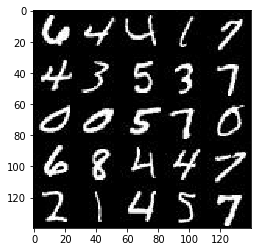

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

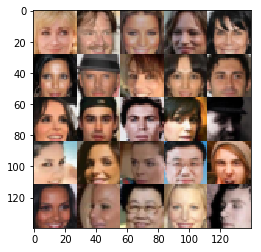

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    x = tf.placeholder(dtype=tf.float32,shape=(None,image_width,image_height,image_channels),name="inputs_x")
    z = tf.placeholder(dtype=tf.float32,shape=(None,z_dim),name="z_dim")
    learning_rate = tf.placeholder(dtype=tf.float32,shape=(),name="learning_rate")

    return x, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope("discriminator",reuse=reuse):
        conv_1 = tf.layers.conv2d(images, 64, 4, strides=2, padding='same')
        conv_1_bn = tf.layers.batch_normalization(conv_1, training=True)
        relu1 = tf.maximum(alpha * conv_1_bn, conv_1_bn)
        # 14x14x64
        
        conv_2 = tf.layers.conv2d(relu1, 128, 4, strides=2, padding='same')
        conv_2_bn = tf.layers.batch_normalization(conv_2, training=True)
        relu2 = tf.maximum(alpha * conv_2_bn, conv_2_bn)
        # 7x7x128
        
        conv_3 = tf.layers.conv2d(relu2, 256, 4, strides=2, padding='same')
        conv_3_bn = tf.layers.batch_normalization(conv_3, training=True)
        relu3 = tf.maximum(alpha * conv_3_bn, conv_3_bn)
        # 4x4x256

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim=5 , is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator',reuse=not(is_train)):
        # Reshape it to start the convolutional stack
        fc = tf.layers.dense(z, 4*4*512)
        x = tf.reshape(fc, (-1, 4, 4, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        relu_x = tf.maximum(alpha * x, x)
        # 4x4x512 now

        #conv2d_1_t = tf.nn.conv2d_transpose(relu_x, kernel, output_shape=[64,7,7,256], strides=[1,2,2,1], padding='SAME')
        conv2d_1_t = tf.layers.conv2d_transpose(relu_x, 256,4, strides=1, padding='valid')
        conv2d_1_t_bn = tf.layers.batch_normalization(conv2d_1_t, training=is_train)
        relu1 = tf.maximum(alpha * conv2d_1_t_bn, conv2d_1_t_bn)
        # 7x7x256 now
        
        conv2d_2_t = tf.layers.conv2d_transpose(relu1, 128, 4, strides=2, padding='same')
        conv2d_2_t_bn = tf.layers.batch_normalization(conv2d_2_t, training=is_train)
        relu2 = tf.maximum(alpha * conv2d_2_t_bn, conv2d_2_t_bn)
        # 14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(relu2, out_channel_dim, 4, strides=2, padding='same')
        # 28x28x3 now
        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*(1 - 0.1)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [20]:
import time
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #print(data_shape)
    input_real,input_z, lr = model_inputs(*data_shape[1:], z_dim)
    
    out_channel_dim = 1
    if data_image_mode == "RGB" : 
        out_channel_dim = 3
    d_loss, g_loss = model_loss(input_real,input_z,out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss,g_loss,lr,beta1)

    steps = 0
    start = time.clock()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                #print(batch_images)
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr :learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr :learning_rate})
                if steps % 100 == 0:
                    end = time.clock()
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Time: {:.4f}s ...Epoch {}/{}...setp:{}...".format((end - start),epoch_i+1, epoch_count,steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    start = time.clock()
                if steps % 500 == 0:
                    show_generator_output(sess,4,input_z,out_channel_dim,data_image_mode)
        show_generator_output(sess,4,input_z,out_channel_dim,data_image_mode)

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Time: 9.2380s ...Epoch 1/2...setp:100... Discriminator Loss: 0.9846... Generator Loss: 1.1315
Time: 6.7183s ...Epoch 1/2...setp:200... Discriminator Loss: 1.1909... Generator Loss: 0.7764
Time: 6.0688s ...Epoch 1/2...setp:300... Discriminator Loss: 1.0154... Generator Loss: 1.1335
Time: 6.4075s ...Epoch 1/2...setp:400... Discriminator Loss: 1.2781... Generator Loss: 1.8121
Time: 5.9563s ...Epoch 1/2...setp:500... Discriminator Loss: 1.4760... Generator Loss: 1.7660


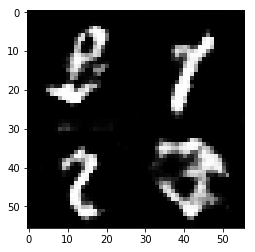

Time: 6.5841s ...Epoch 1/2...setp:600... Discriminator Loss: 1.2770... Generator Loss: 0.7568
Time: 6.7215s ...Epoch 1/2...setp:700... Discriminator Loss: 1.1809... Generator Loss: 0.7591
Time: 7.0664s ...Epoch 1/2...setp:800... Discriminator Loss: 1.2019... Generator Loss: 0.7520
Time: 6.1343s ...Epoch 1/2...setp:900... Discriminator Loss: 1.1831... Generator Loss: 1.2231
Time: 7.0717s ...Epoch 1/2...setp:1000... Discriminator Loss: 0.8245... Generator Loss: 1.2154


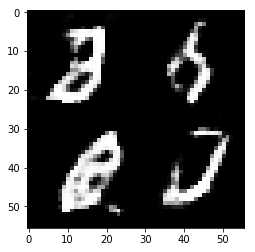

Time: 7.0241s ...Epoch 1/2...setp:1100... Discriminator Loss: 0.9281... Generator Loss: 0.9959
Time: 6.8100s ...Epoch 1/2...setp:1200... Discriminator Loss: 1.3122... Generator Loss: 0.5943
Time: 6.0316s ...Epoch 1/2...setp:1300... Discriminator Loss: 1.1072... Generator Loss: 2.4753
Time: 6.9124s ...Epoch 1/2...setp:1400... Discriminator Loss: 0.9328... Generator Loss: 1.1669
Time: 6.1869s ...Epoch 1/2...setp:1500... Discriminator Loss: 1.0257... Generator Loss: 0.8668


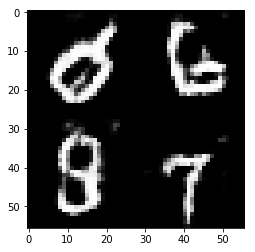

Time: 6.7941s ...Epoch 1/2...setp:1600... Discriminator Loss: 0.5546... Generator Loss: 1.8431
Time: 7.0628s ...Epoch 1/2...setp:1700... Discriminator Loss: 0.7194... Generator Loss: 1.6970
Time: 6.9443s ...Epoch 1/2...setp:1800... Discriminator Loss: 0.9163... Generator Loss: 1.8554
Time: 5.8292s ...Epoch 2/2...setp:1900... Discriminator Loss: 0.7292... Generator Loss: 1.3847
Time: 5.6327s ...Epoch 2/2...setp:2000... Discriminator Loss: 0.8004... Generator Loss: 1.3228


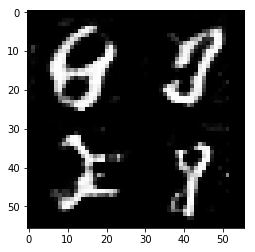

Time: 7.0552s ...Epoch 2/2...setp:2100... Discriminator Loss: 0.5390... Generator Loss: 2.2406
Time: 6.0834s ...Epoch 2/2...setp:2200... Discriminator Loss: 2.2208... Generator Loss: 0.2438
Time: 6.8929s ...Epoch 2/2...setp:2300... Discriminator Loss: 1.3378... Generator Loss: 0.5964
Time: 6.5556s ...Epoch 2/2...setp:2400... Discriminator Loss: 0.5348... Generator Loss: 2.6342
Time: 7.1569s ...Epoch 2/2...setp:2500... Discriminator Loss: 0.7736... Generator Loss: 1.4667


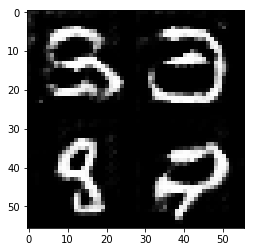

Time: 7.3040s ...Epoch 2/2...setp:2600... Discriminator Loss: 1.1330... Generator Loss: 0.9307
Time: 6.2423s ...Epoch 2/2...setp:2700... Discriminator Loss: 0.7816... Generator Loss: 1.2563
Time: 5.9015s ...Epoch 2/2...setp:2800... Discriminator Loss: 0.8054... Generator Loss: 2.9130
Time: 6.6357s ...Epoch 2/2...setp:2900... Discriminator Loss: 0.9111... Generator Loss: 1.0588
Time: 6.4473s ...Epoch 2/2...setp:3000... Discriminator Loss: 0.5318... Generator Loss: 2.3584


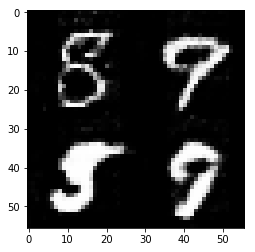

Time: 6.5441s ...Epoch 2/2...setp:3100... Discriminator Loss: 1.4389... Generator Loss: 3.6921
Time: 6.5097s ...Epoch 2/2...setp:3200... Discriminator Loss: 0.6485... Generator Loss: 1.8566
Time: 5.6922s ...Epoch 2/2...setp:3300... Discriminator Loss: 1.4036... Generator Loss: 0.5865
Time: 6.7357s ...Epoch 2/2...setp:3400... Discriminator Loss: 0.8766... Generator Loss: 1.1744
Time: 6.0045s ...Epoch 2/2...setp:3500... Discriminator Loss: 0.5767... Generator Loss: 2.4402


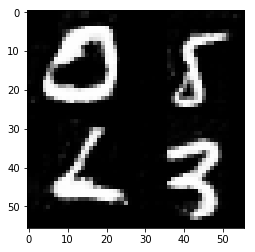

Time: 6.6479s ...Epoch 2/2...setp:3600... Discriminator Loss: 0.5294... Generator Loss: 2.3161
Time: 6.5859s ...Epoch 2/2...setp:3700... Discriminator Loss: 1.0348... Generator Loss: 1.6369


In [17]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Time: 10.7151s ...Epoch 1/1...setp:100... Discriminator Loss: 0.7895... Generator Loss: 1.2172
Time: 8.1568s ...Epoch 1/1...setp:200... Discriminator Loss: 1.1217... Generator Loss: 1.1919
Time: 7.7567s ...Epoch 1/1...setp:300... Discriminator Loss: 1.2003... Generator Loss: 1.2540
Time: 7.9451s ...Epoch 1/1...setp:400... Discriminator Loss: 1.7471... Generator Loss: 0.3584
Time: 8.2154s ...Epoch 1/1...setp:500... Discriminator Loss: 0.9558... Generator Loss: 0.9717


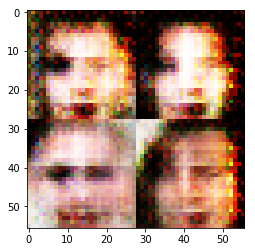

Time: 8.7675s ...Epoch 1/1...setp:600... Discriminator Loss: 1.5347... Generator Loss: 0.8725
Time: 8.0211s ...Epoch 1/1...setp:700... Discriminator Loss: 1.1051... Generator Loss: 0.6979
Time: 8.1703s ...Epoch 1/1...setp:800... Discriminator Loss: 1.0310... Generator Loss: 1.7525
Time: 8.3214s ...Epoch 1/1...setp:900... Discriminator Loss: 1.2622... Generator Loss: 0.8035
Time: 7.8474s ...Epoch 1/1...setp:1000... Discriminator Loss: 1.0797... Generator Loss: 0.8973


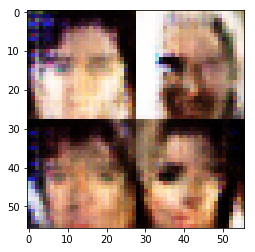

Time: 8.5389s ...Epoch 1/1...setp:1100... Discriminator Loss: 1.4489... Generator Loss: 0.4491
Time: 8.0719s ...Epoch 1/1...setp:1200... Discriminator Loss: 1.2156... Generator Loss: 0.7384
Time: 8.3794s ...Epoch 1/1...setp:1300... Discriminator Loss: 1.5247... Generator Loss: 1.0389
Time: 8.2473s ...Epoch 1/1...setp:1400... Discriminator Loss: 1.5423... Generator Loss: 0.4370
Time: 7.7855s ...Epoch 1/1...setp:1500... Discriminator Loss: 1.4603... Generator Loss: 0.4471


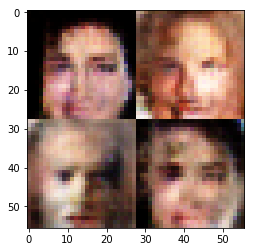

Time: 8.7875s ...Epoch 1/1...setp:1600... Discriminator Loss: 1.3521... Generator Loss: 1.4689
Time: 7.9424s ...Epoch 1/1...setp:1700... Discriminator Loss: 1.1816... Generator Loss: 0.9578
Time: 7.9759s ...Epoch 1/1...setp:1800... Discriminator Loss: 1.2830... Generator Loss: 0.6364
Time: 8.1813s ...Epoch 1/1...setp:1900... Discriminator Loss: 1.1575... Generator Loss: 0.8105
Time: 8.3031s ...Epoch 1/1...setp:2000... Discriminator Loss: 1.3904... Generator Loss: 0.6418


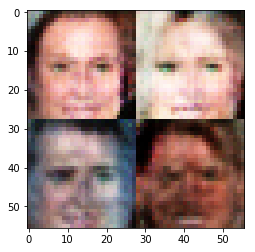

Time: 8.1856s ...Epoch 1/1...setp:2100... Discriminator Loss: 1.1527... Generator Loss: 1.1940
Time: 8.0759s ...Epoch 1/1...setp:2200... Discriminator Loss: 1.2521... Generator Loss: 0.8047
Time: 8.3544s ...Epoch 1/1...setp:2300... Discriminator Loss: 1.3450... Generator Loss: 0.5455
Time: 8.3297s ...Epoch 1/1...setp:2400... Discriminator Loss: 1.1908... Generator Loss: 0.8578
Time: 8.1632s ...Epoch 1/1...setp:2500... Discriminator Loss: 1.1651... Generator Loss: 0.8645


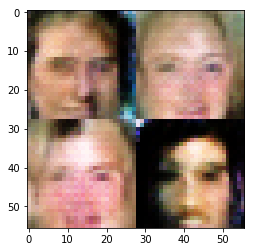

Time: 8.7258s ...Epoch 1/1...setp:2600... Discriminator Loss: 1.2711... Generator Loss: 0.6138
Time: 8.2962s ...Epoch 1/1...setp:2700... Discriminator Loss: 1.2793... Generator Loss: 0.6750
Time: 8.1834s ...Epoch 1/1...setp:2800... Discriminator Loss: 1.3123... Generator Loss: 0.5229
Time: 8.2918s ...Epoch 1/1...setp:2900... Discriminator Loss: 1.1710... Generator Loss: 0.7313
Time: 8.1431s ...Epoch 1/1...setp:3000... Discriminator Loss: 1.1838... Generator Loss: 1.0868


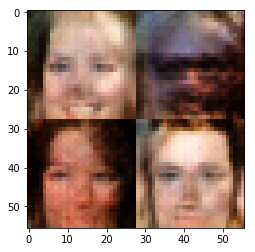

Time: 8.6818s ...Epoch 1/1...setp:3100... Discriminator Loss: 1.3649... Generator Loss: 0.6923
Time: 7.8291s ...Epoch 1/1...setp:3200... Discriminator Loss: 1.0655... Generator Loss: 1.2515
Time: 8.1122s ...Epoch 1/1...setp:3300... Discriminator Loss: 1.1348... Generator Loss: 1.3252
Time: 8.3197s ...Epoch 1/1...setp:3400... Discriminator Loss: 1.0472... Generator Loss: 1.1398
Time: 8.2446s ...Epoch 1/1...setp:3500... Discriminator Loss: 1.3309... Generator Loss: 0.5456


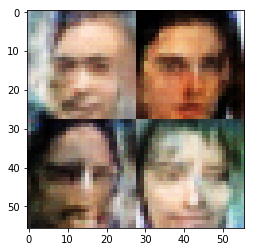

Time: 8.6372s ...Epoch 1/1...setp:3600... Discriminator Loss: 1.3895... Generator Loss: 1.2582
Time: 7.6702s ...Epoch 1/1...setp:3700... Discriminator Loss: 1.2945... Generator Loss: 0.6569
Time: 7.6825s ...Epoch 1/1...setp:3800... Discriminator Loss: 1.2629... Generator Loss: 0.8146
Time: 8.1151s ...Epoch 1/1...setp:3900... Discriminator Loss: 1.4283... Generator Loss: 0.6979
Time: 8.0319s ...Epoch 1/1...setp:4000... Discriminator Loss: 1.0370... Generator Loss: 0.9474


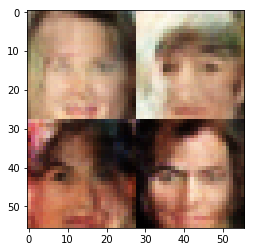

Time: 8.6550s ...Epoch 1/1...setp:4100... Discriminator Loss: 1.4364... Generator Loss: 0.6119
Time: 8.0168s ...Epoch 1/1...setp:4200... Discriminator Loss: 1.2152... Generator Loss: 1.4757
Time: 8.2636s ...Epoch 1/1...setp:4300... Discriminator Loss: 1.3624... Generator Loss: 0.6213
Time: 8.1066s ...Epoch 1/1...setp:4400... Discriminator Loss: 1.4168... Generator Loss: 0.5513
Time: 8.3525s ...Epoch 1/1...setp:4500... Discriminator Loss: 1.3735... Generator Loss: 1.0540


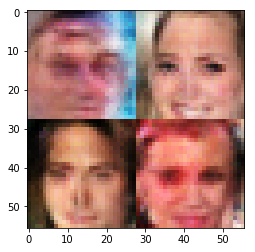

Time: 8.7276s ...Epoch 1/1...setp:4600... Discriminator Loss: 1.5230... Generator Loss: 0.5166
Time: 8.1266s ...Epoch 1/1...setp:4700... Discriminator Loss: 1.2962... Generator Loss: 0.5880
Time: 7.9320s ...Epoch 1/1...setp:4800... Discriminator Loss: 1.0238... Generator Loss: 0.8950
Time: 8.0869s ...Epoch 1/1...setp:4900... Discriminator Loss: 1.3377... Generator Loss: 0.5583
Time: 7.7236s ...Epoch 1/1...setp:5000... Discriminator Loss: 1.3289... Generator Loss: 0.6942


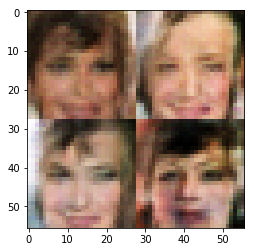

Time: 8.7732s ...Epoch 1/1...setp:5100... Discriminator Loss: 1.1237... Generator Loss: 0.7693
Time: 7.8695s ...Epoch 1/1...setp:5200... Discriminator Loss: 1.0499... Generator Loss: 1.3566
Time: 7.9551s ...Epoch 1/1...setp:5300... Discriminator Loss: 1.1443... Generator Loss: 0.7266
Time: 7.4906s ...Epoch 1/1...setp:5400... Discriminator Loss: 1.4427... Generator Loss: 0.7298
Time: 7.3214s ...Epoch 1/1...setp:5500... Discriminator Loss: 1.1495... Generator Loss: 0.8375


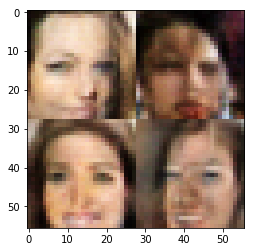

Time: 8.3884s ...Epoch 1/1...setp:5600... Discriminator Loss: 1.0520... Generator Loss: 0.8246
Time: 8.3799s ...Epoch 1/1...setp:5700... Discriminator Loss: 1.3862... Generator Loss: 0.6060
Time: 8.2883s ...Epoch 1/1...setp:5800... Discriminator Loss: 1.1972... Generator Loss: 1.1040
Time: 8.0298s ...Epoch 1/1...setp:5900... Discriminator Loss: 1.1223... Generator Loss: 0.9187
Time: 7.5334s ...Epoch 1/1...setp:6000... Discriminator Loss: 1.1178... Generator Loss: 0.9183


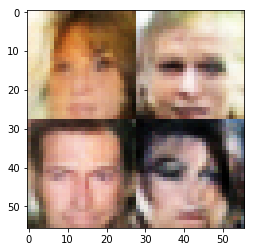

Time: 9.0263s ...Epoch 1/1...setp:6100... Discriminator Loss: 1.3596... Generator Loss: 0.5362
Time: 7.6155s ...Epoch 1/1...setp:6200... Discriminator Loss: 1.1055... Generator Loss: 0.8145
Time: 7.9134s ...Epoch 1/1...setp:6300... Discriminator Loss: 1.0381... Generator Loss: 0.9273
Time: 8.1024s ...Epoch 1/1...setp:6400... Discriminator Loss: 1.3573... Generator Loss: 0.7118
Time: 8.2074s ...Epoch 1/1...setp:6500... Discriminator Loss: 1.7251... Generator Loss: 0.3582


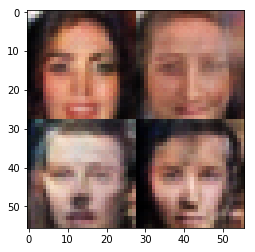

Time: 8.2921s ...Epoch 1/1...setp:6600... Discriminator Loss: 1.6099... Generator Loss: 0.3804
Time: 7.6543s ...Epoch 1/1...setp:6700... Discriminator Loss: 1.0882... Generator Loss: 0.8045
Time: 7.8165s ...Epoch 1/1...setp:6800... Discriminator Loss: 1.0968... Generator Loss: 0.9006
Time: 7.8274s ...Epoch 1/1...setp:6900... Discriminator Loss: 1.3311... Generator Loss: 0.5774
Time: 7.7232s ...Epoch 1/1...setp:7000... Discriminator Loss: 1.1748... Generator Loss: 0.8115


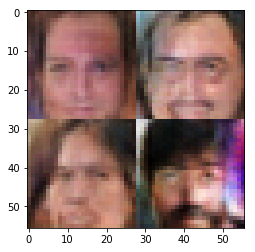

Time: 8.5843s ...Epoch 1/1...setp:7100... Discriminator Loss: 1.2145... Generator Loss: 0.6027
Time: 8.2534s ...Epoch 1/1...setp:7200... Discriminator Loss: 0.9352... Generator Loss: 1.0945
Time: 7.8282s ...Epoch 1/1...setp:7300... Discriminator Loss: 1.6031... Generator Loss: 0.4291
Time: 7.9139s ...Epoch 1/1...setp:7400... Discriminator Loss: 1.3132... Generator Loss: 0.6097
Time: 7.7473s ...Epoch 1/1...setp:7500... Discriminator Loss: 1.5995... Generator Loss: 0.3621


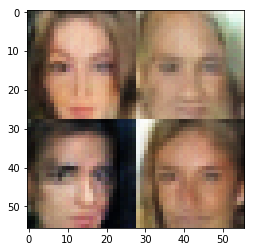

Time: 8.3054s ...Epoch 1/1...setp:7600... Discriminator Loss: 1.4743... Generator Loss: 0.4681
Time: 7.4649s ...Epoch 1/1...setp:7700... Discriminator Loss: 1.0994... Generator Loss: 0.8262
Time: 8.0436s ...Epoch 1/1...setp:7800... Discriminator Loss: 1.0483... Generator Loss: 1.4853
Time: 7.5914s ...Epoch 1/1...setp:7900... Discriminator Loss: 1.0376... Generator Loss: 1.0385
Time: 7.9908s ...Epoch 1/1...setp:8000... Discriminator Loss: 1.0002... Generator Loss: 0.8505


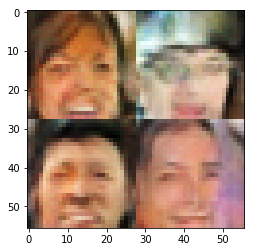

Time: 8.2520s ...Epoch 1/1...setp:8100... Discriminator Loss: 1.2263... Generator Loss: 0.6230
Time: 8.0151s ...Epoch 1/1...setp:8200... Discriminator Loss: 1.4598... Generator Loss: 0.4824
Time: 7.9991s ...Epoch 1/1...setp:8300... Discriminator Loss: 0.9401... Generator Loss: 1.5078
Time: 7.6592s ...Epoch 1/1...setp:8400... Discriminator Loss: 1.0604... Generator Loss: 1.2336
Time: 7.9749s ...Epoch 1/1...setp:8500... Discriminator Loss: 1.6365... Generator Loss: 0.3917


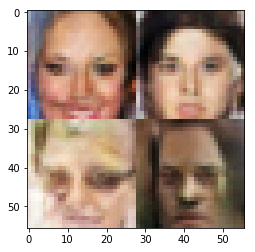

Time: 8.5070s ...Epoch 1/1...setp:8600... Discriminator Loss: 0.8736... Generator Loss: 1.4344
Time: 8.1731s ...Epoch 1/1...setp:8700... Discriminator Loss: 1.5075... Generator Loss: 0.4014
Time: 7.9298s ...Epoch 1/1...setp:8800... Discriminator Loss: 1.3532... Generator Loss: 0.5270
Time: 8.1917s ...Epoch 1/1...setp:8900... Discriminator Loss: 0.9513... Generator Loss: 1.2962
Time: 8.1837s ...Epoch 1/1...setp:9000... Discriminator Loss: 1.1362... Generator Loss: 0.9014


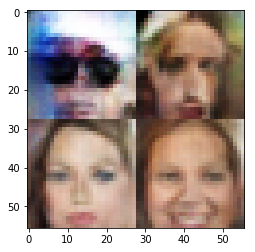

Time: 8.1009s ...Epoch 1/1...setp:9100... Discriminator Loss: 1.4193... Generator Loss: 0.6038
Time: 7.8877s ...Epoch 1/1...setp:9200... Discriminator Loss: 1.3410... Generator Loss: 0.6606
Time: 7.4087s ...Epoch 1/1...setp:9300... Discriminator Loss: 0.9545... Generator Loss: 1.5802
Time: 8.0190s ...Epoch 1/1...setp:9400... Discriminator Loss: 1.0562... Generator Loss: 1.4346
Time: 8.1211s ...Epoch 1/1...setp:9500... Discriminator Loss: 0.8765... Generator Loss: 1.1467


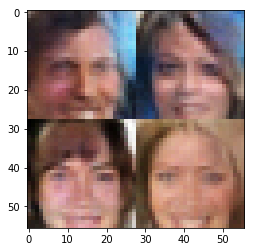

Time: 8.5616s ...Epoch 1/1...setp:9600... Discriminator Loss: 1.4919... Generator Loss: 0.5227
Time: 7.6352s ...Epoch 1/1...setp:9700... Discriminator Loss: 1.0078... Generator Loss: 1.0879
Time: 7.5564s ...Epoch 1/1...setp:9800... Discriminator Loss: 1.6000... Generator Loss: 0.5052
Time: 7.7166s ...Epoch 1/1...setp:9900... Discriminator Loss: 1.4873... Generator Loss: 0.4861
Time: 7.9969s ...Epoch 1/1...setp:10000... Discriminator Loss: 0.9095... Generator Loss: 1.0679


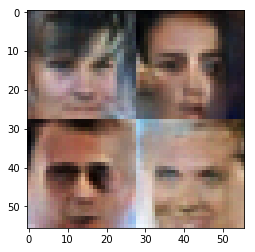

Time: 8.0289s ...Epoch 1/1...setp:10100... Discriminator Loss: 1.3601... Generator Loss: 0.5205
Time: 7.4191s ...Epoch 1/1...setp:10200... Discriminator Loss: 0.8073... Generator Loss: 1.1741
Time: 8.2780s ...Epoch 1/1...setp:10300... Discriminator Loss: 1.1970... Generator Loss: 0.7710
Time: 7.6688s ...Epoch 1/1...setp:10400... Discriminator Loss: 0.8099... Generator Loss: 1.7495
Time: 7.7811s ...Epoch 1/1...setp:10500... Discriminator Loss: 0.8870... Generator Loss: 0.9943


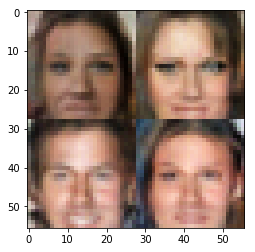

Time: 8.3883s ...Epoch 1/1...setp:10600... Discriminator Loss: 1.7093... Generator Loss: 0.3695
Time: 8.3901s ...Epoch 1/1...setp:10700... Discriminator Loss: 0.7756... Generator Loss: 1.3692
Time: 8.1511s ...Epoch 1/1...setp:10800... Discriminator Loss: 1.3593... Generator Loss: 0.5254
Time: 7.3496s ...Epoch 1/1...setp:10900... Discriminator Loss: 1.5458... Generator Loss: 0.4355
Time: 8.0450s ...Epoch 1/1...setp:11000... Discriminator Loss: 1.2263... Generator Loss: 0.7428


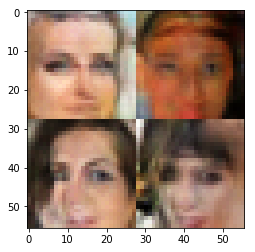

Time: 8.2137s ...Epoch 1/1...setp:11100... Discriminator Loss: 0.6784... Generator Loss: 2.8342
Time: 7.2522s ...Epoch 1/1...setp:11200... Discriminator Loss: 0.9173... Generator Loss: 1.5660
Time: 7.4469s ...Epoch 1/1...setp:11300... Discriminator Loss: 1.2874... Generator Loss: 0.7139
Time: 7.9204s ...Epoch 1/1...setp:11400... Discriminator Loss: 0.7507... Generator Loss: 1.3276
Time: 7.6740s ...Epoch 1/1...setp:11500... Discriminator Loss: 0.7804... Generator Loss: 1.3889


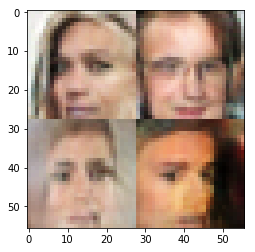

Time: 8.2661s ...Epoch 1/1...setp:11600... Discriminator Loss: 0.7142... Generator Loss: 1.5612
Time: 7.6162s ...Epoch 1/1...setp:11700... Discriminator Loss: 1.2638... Generator Loss: 0.6761
Time: 7.6969s ...Epoch 1/1...setp:11800... Discriminator Loss: 1.4009... Generator Loss: 0.4760
Time: 7.4397s ...Epoch 1/1...setp:11900... Discriminator Loss: 1.0353... Generator Loss: 1.3951
Time: 8.0737s ...Epoch 1/1...setp:12000... Discriminator Loss: 0.6438... Generator Loss: 2.2630


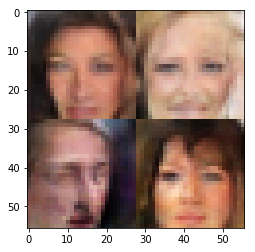

Time: 8.2351s ...Epoch 1/1...setp:12100... Discriminator Loss: 0.5144... Generator Loss: 2.3444
Time: 7.5968s ...Epoch 1/1...setp:12200... Discriminator Loss: 0.5644... Generator Loss: 1.9778
Time: 8.2889s ...Epoch 1/1...setp:12300... Discriminator Loss: 0.8566... Generator Loss: 1.0365
Time: 7.3509s ...Epoch 1/1...setp:12400... Discriminator Loss: 0.6374... Generator Loss: 1.8874
Time: 7.4781s ...Epoch 1/1...setp:12500... Discriminator Loss: 1.6388... Generator Loss: 0.4379


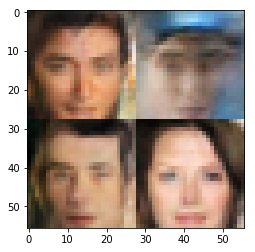

Time: 8.5910s ...Epoch 1/1...setp:12600... Discriminator Loss: 1.0968... Generator Loss: 0.7431


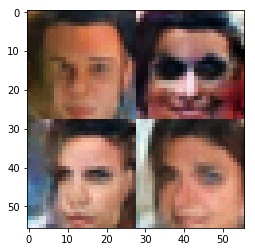

In [21]:
batch_size = 16
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。